### Importing libraries

In [635]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import csv

### Ingesting Data

In [636]:
train = pd.read_csv('datasets/train.csv', index_col='Id', keep_default_na=False,
                                                       # na_values=
                                                        )
test =  pd.read_csv('datasets/test.csv', index_col='Id', keep_default_na=False,
                                                        #na_values=
                                                        )
#data = pd.concat([train, test])
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


### Changing Types

In [637]:
def clean_data(train):
    # Replace all instances of "NA" with "0" in column: 'LotFrontage'
    train['LotFrontage'] = train['LotFrontage'].str.replace("NA", "0", case=False, regex=False)
    # Change column type to float64 for column: 'LotFrontage'
    train = train.astype({'LotFrontage': 'float64'})
    # Change column type to category for column: 'MSSubClass'
    # train = train.astype({'MSSubClass': 'category'})
    # Change column type to category for column: 'MSZoning'
    # train = train.astype({'MSZoning': 'category'})
    # Change column type to category for column: 'Street'
    # train = train.astype({'Street': 'category'})
    # Change column type to category for columns: 'Alley', 'LotShape' and 14 other columns
    # train = train.astype({'Alley': 'category', 'LotShape': 'category', 'LandContour': 'category', 'Utilities': 'category', 'LotConfig': 'category', 'LandSlope': 'category', 'Neighborhood': 'category', 'Condition1': 'category', 'Condition2': 'category', 'BldgType': 'category', 'HouseStyle': 'category', 'RoofStyle': 'category', 'RoofMatl': 'category', 'Exterior1st': 'category', 'MasVnrType': 'category', 'Exterior2nd': 'category'})
    # Replace all instances of 0 with -0.1 in column: 'LotFrontage'
    train.loc[train['LotFrontage'] == 0, 'LotFrontage'] = np.nan
    # Replace all instances of "na" with "0" in column: 'MasVnrArea'
    train['MasVnrArea'] = train['MasVnrArea'].str.replace("na", "0", case=False, regex=False)
    # Change column type to float64 for column: 'MasVnrArea'
    train = train.astype({'MasVnrArea': 'float64'})
    # Change column type to category for columns: 'ExterQual', 'ExterCond' and 21 other columns
    # train = train.astype({'ExterQual': 'category', 'ExterCond': 'category', 'Foundation': 'category', 'BsmtQual': 'category', 'BsmtCond': 'category', 'BsmtExposure': 'category', 'BsmtFinType1': 'category', 'BsmtFinType2': 'category', 'Heating': 'category', 'HeatingQC': 'category', 'CentralAir': 'category', 'Electrical': 'category', 'KitchenQual': 'category', 'Functional': 'category', 'FireplaceQu': 'category', 'GarageType': 'category', 'GarageFinish': 'category', 'GarageQual': 'category', 'GarageCond': 'category', 'PavedDrive': 'category', 'PoolQC': 'category', 'Fence': 'category', 'MiscFeature': 'category'})
    # Change column type to category for columns: 'SaleType', 'SaleCondition'
    # train = train.astype({'SaleType': 'category', 'SaleCondition': 'category','GarageYrBlt': 'category',
                        #   'YearRemodAdd': 'category','YearBuilt': 'category','YrSold': 'category',
                        #   'OverallQual': 'category','OverallCond': 'category','MoSold': 'category'})
    return train

train_clean = clean_data(train.copy())
train_clean.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


In [638]:
test_clean = clean_data(test.copy())
test_clean.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NA,Reg,Lvl,AllPub,Inside,...,120,0,NA,MnPrv,NA,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,NA,MnPrv,NA,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NA,IR1,HLS,AllPub,Inside,...,144,0,NA,NA,NA,0,1,2010,WD,Normal


### Ingesting Description Data

In [639]:
data_description = pd.read_csv('datasets/data_description.txt',
                                sep=r'[\t:]',
                                na_filter=False,
                                header=None,
                                names = ['variable','description'],
                                # na_values= ['UNK'],
                                on_bad_lines='skip',
                                skip_blank_lines=False,
                                skipinitialspace=False,
                                # iterator=True,
                                # chunksize=1
                                

)
data_description.drop(axis='rows', index=373, inplace=True )


C:\Users\gylbt\AppData\Local\Temp\ipykernel_26012\1097721812.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_description = pd.read_csv('datasets/data_description.txt',


In [640]:
data_description 

,variable,description
0,MSSubClass,Identifies the type of dwelling involved in t...
1,20,1-STORY 1946 & NEWER ALL STYLES
2,30,1-STORY 1945 & OLDER
3,40,1-STORY W/FINISHED ATTIC ALL AGES
4,45,1-1/2 STORY - UNFINISHED ALL AGES
...,...,...
469,Abnorml,"Abnormal Sale - trade, foreclosure, short sale"
470,AdjLand,Adjoining Land Purchase
471,Alloca,Allocation - two linked properties with...
472,Family,Sale between family members


In [641]:
breaks = data_description.query('description.isna()').index.to_list()
vars = []

for brk in breaks:
    vars.append(data_description.at[brk+1, 'variable'] )

vars.insert(0, data_description.at[0, 'variable'])
data_description.insert(1, 'category', 'see')

In [642]:
i=0
x=0
for brk in breaks:
    data_description.loc[i: brk, 'category'] = vars[x]
    i=breaks[x]+1
    x+=1
    if brk==462:
        data_description.loc[brk:, 'category'] = vars[x]
        break

data_description.loc[data_description['category'] == "see", 'category'] = "SaleCondition"

data_description.drop(breaks, axis=0, inplace=True)
data_description


,variable,category,description
0,MSSubClass,MSSubClass,Identifies the type of dwelling involved in t...
1,20,MSSubClass,1-STORY 1946 & NEWER ALL STYLES
2,30,MSSubClass,1-STORY 1945 & OLDER
3,40,MSSubClass,1-STORY W/FINISHED ATTIC ALL AGES
4,45,MSSubClass,1-1/2 STORY - UNFINISHED ALL AGES
...,...,...,...
469,Abnorml,SaleCondition,"Abnormal Sale - trade, foreclosure, short sale"
470,AdjLand,SaleCondition,Adjoining Land Purchase
471,Alloca,SaleCondition,Allocation - two linked properties with...
472,Family,SaleCondition,Sale between family members


In [643]:
desc = data_description.query('variable == category').index
data_description.drop(desc, inplace=True  )


In [644]:
na = list(data_description.query("variable == 'NA' ").category.values)
n_na= set(train_clean.columns).difference(set(na))
# n_na

In [645]:

for col in n_na:
    if train_clean[col].eq("NA").sum() > 0:
        print(col)
    # else:




MasVnrType
GarageYrBlt
Alley
Electrical


### Ordinal Variables

In [646]:
ordinal = ['LotShape','LandSlope','OverallQual','OverallCond',
           'ExterQual','ExterCond','BsmtQual','BsmtCond',
           'BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC',
           'KitchenQual','Functional','FireplaceQu','GarageFinish',
           'GarageQual','GarageCond','PavedDrive','PoolQC',
           'Fence']

In [647]:
time_col = ['YearBuilt','YearRemodAdd','YrSold','GarageYrBlt','MoSold']
floats = [col for col in train_clean.select_dtypes('number').columns.to_list()]


### Data Exploration

In [648]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [649]:
train_clean.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [650]:
train_clean_cat = train_clean.select_dtypes('category').astype('string', copy=False)

train
# obj_cols  = train_clean.columns.to_list()
# repl = []
# for col in obj_cols:
#     if train_clean[col].str.isnumeric().sum() > 100:
#         print(col) 
#         repl.append(col)
train_clean

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,MnPrv,NA,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,GdPrv,Shed,2500,5,2010,WD,Normal,266500


### Change to float

In [651]:
# for col in repl:
#     train_clean[col].replace('NA', np.nan, inplace=True)
#     test[col].replace('NA', np.nan, inplace=True)
#     train_clean[col] = train_clean[col].astype(float)
#     test[col] = test[col].astype(float)
def clean_data(train_clean):
    # Change column type to object for column: 'MasVnrType'
    train_clean = train_clean.astype({'MasVnrType': 'object','Electrical': 'object', 'GarageYrBlt': 'object',})
    # Replace all instances of "NA" with "" in columns: 'MasVnrType', 'Electrical', 'GarageYrBlt'
    train_clean.loc[train_clean['MasVnrType'] == "NA", 'MasVnrType'] = None
    train_clean.loc[train_clean['Electrical'] == "NA", 'Electrical'] = None
    train_clean.loc[train_clean['GarageYrBlt'] == "NA", 'GarageYrBlt'] = None
    return train_clean

train_clean = clean_data(train_clean)
test_clean = clean_data(test_clean)


In [652]:
train_clean

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,MnPrv,NA,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,GdPrv,Shed,2500,5,2010,WD,Normal,266500


### Variable Distribution

c:\Users\gylbt\anaconda3\envs\ml.venv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


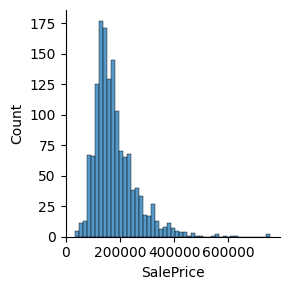

In [653]:
grid = sns.FacetGrid(train_clean)
grid.map(sns.histplot, 'SalePrice')
plt.savefig('histograms.jpg')

## Missing Data

In [654]:
def check_missing(df=train_clean):
    missing = df.isna().sum()
    missing_data = missing[missing > 0]
    return missing_data

check_missing()

LotFrontage    259
MasVnrType       8
Electrical       1
GarageYrBlt     81
dtype: int64

<Axes: >

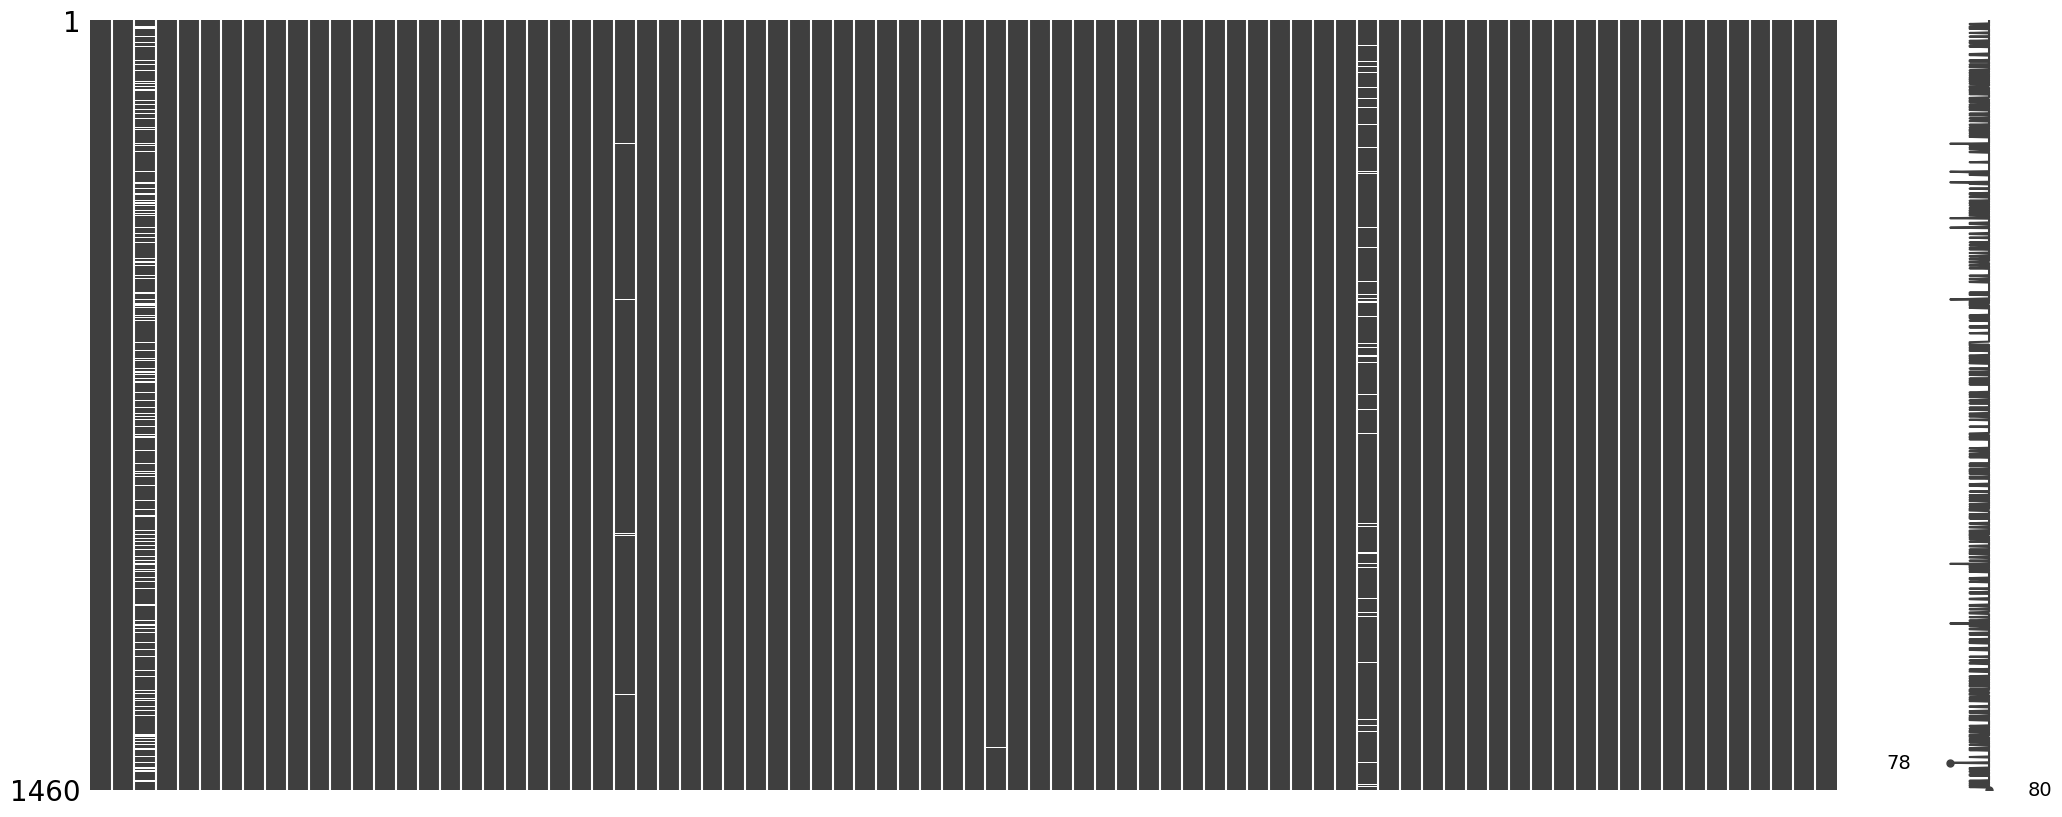

In [655]:
msno.matrix(train_clean)

<Axes: >

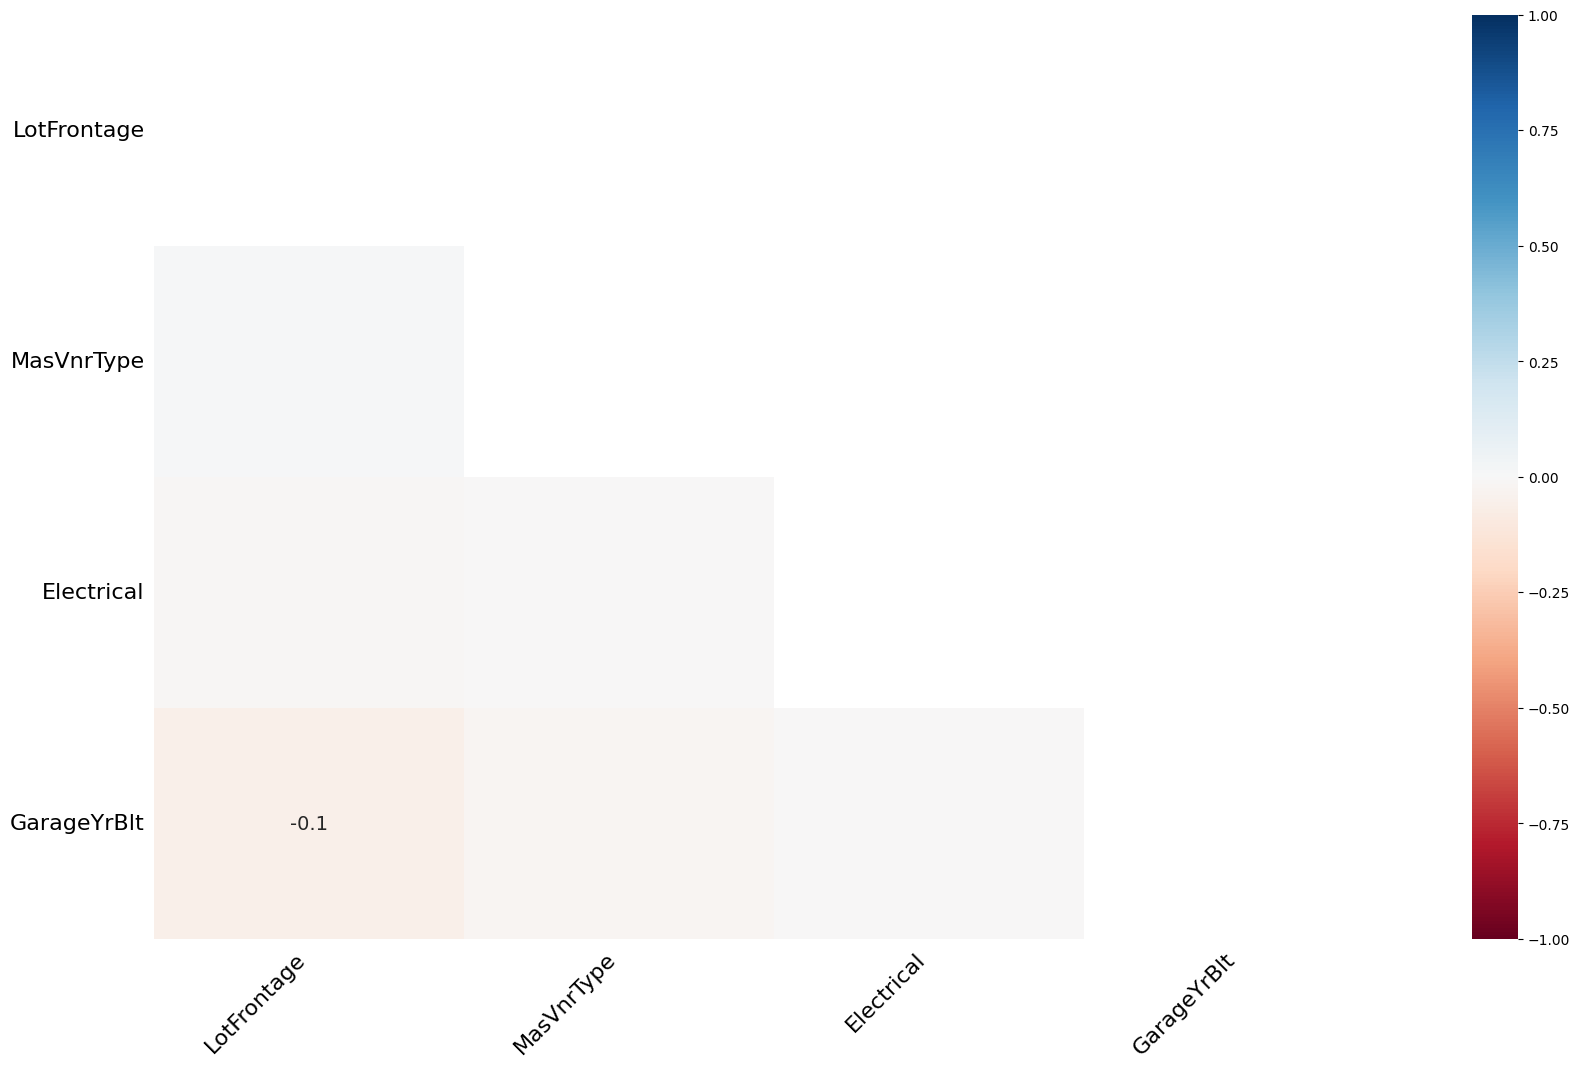

In [656]:
msno.heatmap(train_clean)

# Fill Missing Data

### YearBuilt

In [657]:
corr = train_clean[["GarageYrBlt", "YearBuilt"]].corr()
corr

,GarageYrBlt,YearBuilt
GarageYrBlt,1.000000,0.825667
YearBuilt,0.825667,1.000000


In [658]:
train_clean["GarageYrBlt"].fillna(train_clean["YearBuilt"],inplace=True)
test["GarageYrBlt"].fillna(test["YearBuilt"],inplace=True)


## LotFrontage

In [659]:
check_missing()

LotFrontage    259
MasVnrType       8
Electrical       1
dtype: int64

c:\Users\gylbt\anaconda3\envs\ml.venv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


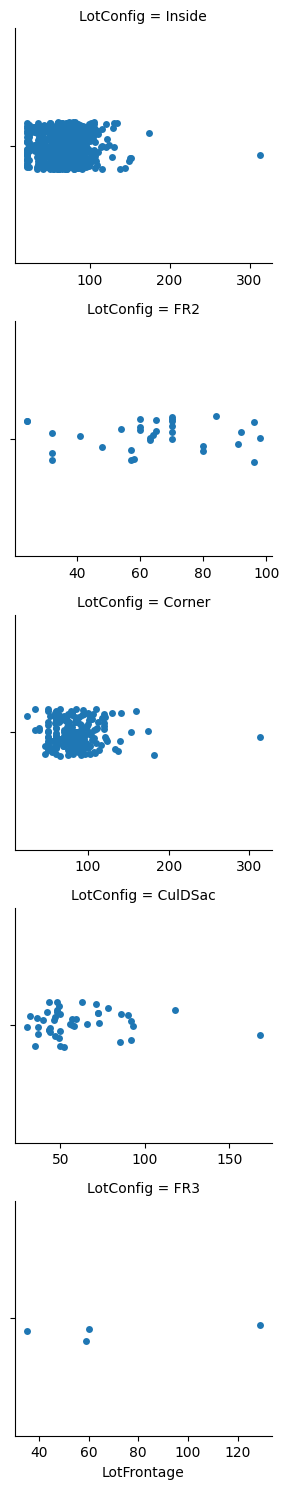

In [660]:
sns.catplot(data=train_clean, x='LotFrontage',kind='strip', row='LotConfig', sharex=False,height=3,orient='portrait')

plt.show()


In [661]:
lot_front_dic = train_clean.mask(train_clean.LotFrontage.isna()) \
            .groupby('LotConfig') \
                ['LotFrontage'].median().round() \
                .to_dict()

lot_front_dic

{'Corner': 80.0, 'CulDSac': 50.0, 'FR2': 64.0, 'FR3': 60.0, 'Inside': 68.0}

In [662]:
# missing_LF = train_clean[(train_clean.LotConfig == key) & (train_clean.LotFrontage.isna())]  

for key, item in lot_front_dic.items():
    train_clean.loc[(train_clean.LotConfig==key ) & (train_clean.LotFrontage.isna()), 'LotFrontage'] = item
    # test.loc[(train_clean.LotConfig==key ) & (train_clean.LotFrontage.isna()), 'LotFrontage'] = item

In [663]:
train_clean.MasVnrType.fillna('None', inplace=True)

In [664]:
train_clean.Electrical.fillna(method='pad', inplace=True)

In [665]:
check_missing(train_clean)

Series([], dtype: int64)

In [666]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [667]:
train_clean.to_csv('datasets/train_clean_clean.csv')
test_clean.to_csv('datasets/test_clean.csv')

# Drop Columns

### Drop Columns Dominated by a certain value

In [668]:
# unbalanced_cols = []
# for col in train_clean.select_dtypes('object').columns:
#     value_counts = train_clean[col].value_counts(normalize=True)

#     max = value_counts.max()
    
#     print(value_counts)
#    # print(max)

#     if max > .70:
#         unbalanced_cols.append(col)


In [669]:
# train_clean.drop(unbalanced_cols, axis='columns',inplace=True)
# check_missing()

In [670]:
# train_clean.dropna(axis=0,inplace=True)
# print(train_clean.shape)
# check_missing()

# Feature Importance

## Correlation of Predictors with Target Variables

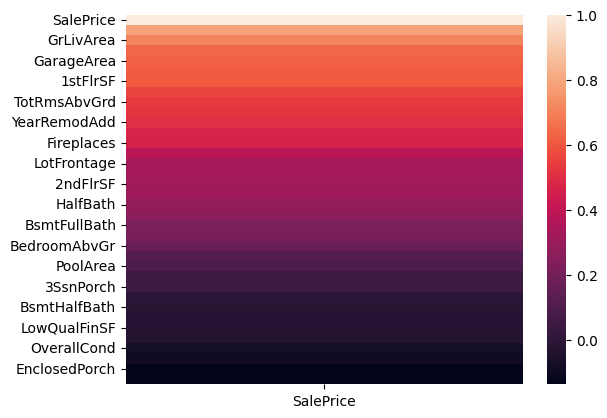

In [671]:
# def plot_correlation_heatmap(target_col: str or None):

#     corr_data: pd.DataFrame
    
#     if target_col is None:
corr_price = train_clean.corr(method='pearson', numeric_only=True)['SalePrice'].sort_values(ascending=False)
#     elif isinstance(target_col, str):
#         corr_data = train_clean.corr(method='pearson')

sns.heatmap(corr_price.to_frame())
plt.show()

# plot_correlation_heatmap('SalePrice')

## Correlation between Predictor Variables (Multicollinearity)

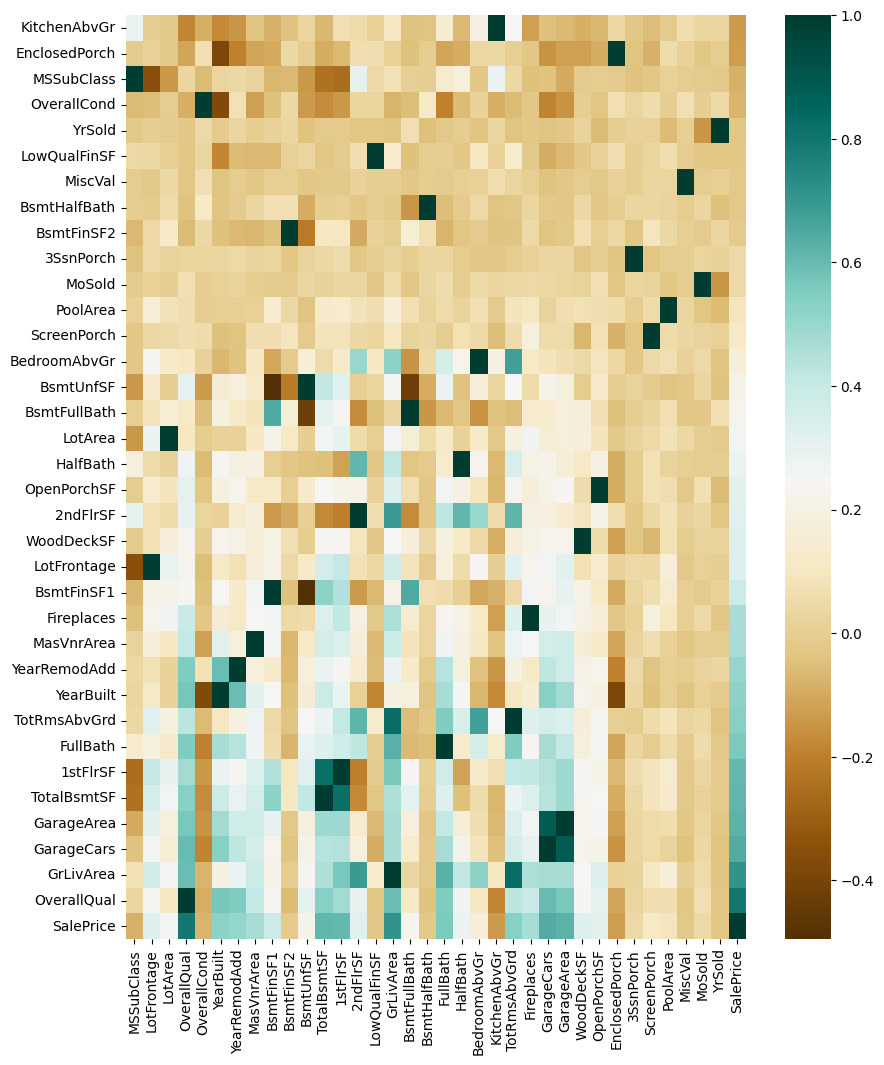

In [672]:
corr_df = train_clean.corr(method='pearson', numeric_only=True).sort_values(by='SalePrice')
fig = plt.figure(figsize=(10,12))
sns.heatmap(corr_df,cmap='BrBG', figure=fig )
plt.show()

In [673]:
corr_df.index


Index(['KitchenAbvGr', 'EnclosedPorch', 'MSSubClass', 'OverallCond', 'YrSold',
       'LowQualFinSF', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2', '3SsnPorch',
       'MoSold', 'PoolArea', 'ScreenPorch', 'BedroomAbvGr', 'BsmtUnfSF',
       'BsmtFullBath', 'LotArea', 'HalfBath', 'OpenPorchSF', '2ndFlrSF',
       'WoodDeckSF', 'LotFrontage', 'BsmtFinSF1', 'Fireplaces', 'MasVnrArea',
       'YearRemodAdd', 'YearBuilt', 'TotRmsAbvGrd', 'FullBath', '1stFlrSF',
       'TotalBsmtSF', 'GarageArea', 'GarageCars', 'GrLivArea', 'OverallQual',
       'SalePrice'],
      dtype='object')

## Drop highly correlated independent variables

In [674]:
# corrTol = 0.65

# for col in corr_df:
#     if col in corr_df.keys():
#         thisCol = []
#         thisVars = []

#         for i in range(len(corr_df)):
#             if abs(corr_df[col][i]) == 1.0 and col != corr_df.keys()[i]:
#                 thisCorr = 0
#             else:
#                 thisCorr = ( 1 if abs(corr_df[col][i]) > corrTol else -1)
            
#             thisCol.append(thisCorr)
#             thisVars.append(corr_df.keys()[i])
        
#         mask = np.ones(len(thisCol), dtype=bool)

#         ctDelCol = 0

#         for n, j in enumerate(thisCol):
#             # is the correlation greater than 0not equal to the max corr and greater than ze
#             mask[n] = not (j != max(thisCol) and j>=0)

#             if j != max(thisCol) and j >= 0:
#                 corr_df.pop('%s' %thisVars[n])
#                 train_clean.pop('%s' %thisVars[n])
#                 ctDelCol += 1

#         corr_df = corr_df[mask]

In [675]:
cols_del = []
tol = .65

for col, row in corr_df.iterrows():
    # print(col)
    # print(row)
    # print(f"Current column {col}")
    for col2, corr in row.items():
        # print(f"Checking correlation with {col2}")
        if abs(corr) > tol and col2 != col:
            # print(f"Correlation of {corr} is greater than the tolerance of {tol}")
            # print("Adding it to deleted columns")
            corr_target = corr_df.loc[col, 'SalePrice']
            corr_target2 = corr_df.loc[col2, 'SalePrice']
            if corr_target > corr_target2:
                cols_del.append(col2)
            else:
                cols_del.append(col)

cols_del = list(set(cols_del))


In [676]:
cols_del

['1stFlrSF',
 'BedroomAbvGr',
 'GarageArea',
 'GrLivArea',
 'OverallQual',
 'TotRmsAbvGrd',
 '2ndFlrSF']

In [677]:
# train_clean.drop(columns=cols_del, inplace=True)
# corr_df.drop(columns=cols_del, inplace=True)
# train_clean


In [678]:
import pingouin
cats = train_clean.select_dtypes('object').columns.to_list()

frames = []
for col in range(len(cats)):
    frame = pingouin.welch_anova(data=train_clean, dv='SalePrice', between=cats[col]).round(3)
    frames.append(frame)

c:\Users\gylbt\anaconda3\envs\ml.venv\lib\site-packages\pingouin\parametric.py:1356: RuntimeWarning: divide by zero encountered in double_scalars
  pval = f.sf(fval, ddof1, 1 / lamb)
c:\Users\gylbt\anaconda3\envs\ml.venv\lib\site-packages\pingouin\parametric.py:1364: RuntimeWarning: divide by zero encountered in double_scalars
  "ddof2": 1 / lamb,


In [679]:
c = pd.concat(frames)
c.loc[c["p-unc"] > 0.05]

,Source,ddof1,ddof2,F,p-unc,np2
0,Street,1,5.061,3.613,0.115,0.002
0,Utilities,1,inf,0.000,1.000,0.000
0,LandSlope,2,27.571,1.489,0.243,0.003
0,PoolQC,3,2.008,0.570,0.687,0.021
0,MiscFeature,4,4.020,3.532,0.124,0.007


In [680]:
# frames = []
# for col in range(len(cats)):
#     frame = pingouin.normality(data=train_clean, dv='SalePrice', group=cats[col]).round(3)
#     frames.append(frame)

In [681]:
norm = pd.concat(frames)
norm

,Source,ddof1,ddof2,F,p-unc,np2
0,MSZoning,4,43.893,95.072,0.000,0.108
0,Street,1,5.061,3.613,0.115,0.002
0,Alley,2,75.904,64.562,0.000,0.020
0,LotShape,3,36.947,33.030,0.000,0.076
0,LandContour,3,83.334,16.302,0.000,0.026
0,Utilities,1,inf,0.000,1.000,0.000
0,LotConfig,4,21.992,5.319,0.004,0.021
0,LandSlope,2,27.571,1.489,0.243,0.003
0,Neighborhood,24,120.907,56.151,0.000,0.546
0,Condition1,8,21.544,14.447,0.000,0.033


In [682]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif



# for col in cats:
    
# X_new = SelectKBest(f_classif, k=15).fit_transform(train_X, train_y)
# X_new.shape


# Binarize, Convert to Ordinal

In [683]:


ordinal = ['LotShape','LandSlope','OverallQual','OverallCond',
            'ExterQual','ExterCond','BsmtQual','BsmtCond',
            'BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC',
            'KitchenQual','Functional','FireplaceQu','GarageFinish',
            'GarageQual','GarageCond','PavedDrive','PoolQC',
            'Fence']

time_col = ['YearBuilt','YearRemodAdd','YrSold','GarageYrBlt','MoSold']
floats = [col for col in train_clean.select_dtypes('number').columns.to_list()]


In [684]:

def binarize(train_clean):
    
    for col in train_clean.columns:
        if col not in ordinal and col not in time_col and col not in floats:
            train_clean = pd.get_dummies(train_clean, columns=[col], drop_first=True)
    return train_clean


In [685]:

train_clean = binarize(train_clean)
train_clean.head()

,MSSubClass,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,Reg,Gtl,7,5,2003,2003,196.0,...,False,False,False,False,True,False,False,False,True,False
2,20,80.0,9600,Reg,Gtl,6,8,1976,1976,0.0,...,False,False,False,False,True,False,False,False,True,False
3,60,68.0,11250,IR1,Gtl,7,5,2001,2002,162.0,...,False,False,False,False,True,False,False,False,True,False
4,70,60.0,9550,IR1,Gtl,7,5,1915,1970,0.0,...,False,False,False,False,True,False,False,False,False,False
5,60,84.0,14260,IR1,Gtl,8,5,2000,2000,350.0,...,False,False,False,False,True,False,False,False,True,False


In [688]:
all_ordinal = time_col + ordinal
set(all_ordinal).difference(set(ordinal))

{'GarageYrBlt', 'MoSold', 'YearBuilt', 'YearRemodAdd', 'YrSold'}

In [687]:
order = dict ()

for col in all_ordinal:
    x = data_description.loc[data_description['category']== col, 'variable'].to_list()
    order[col] = x

print(order)
                     

{'YearBuilt': [], 'YearRemodAdd': [], 'YrSold': [], 'GarageYrBlt': [], 'MoSold': [], 'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'], 'LandSlope': ['Gtl', 'Mod', 'Sev'], 'OverallQual': ['10', '9', '8', '7', '6', '5', '4', '3', '2', '1'], 'OverallCond': ['10', '9', '8', '7', '6', '5', '4', '3', '2', '1'], 'ExterQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po'], 'ExterCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po'], 'BsmtQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], 'BsmtCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], 'BsmtExposure': ['Gd', 'Av', 'Mn', 'No', 'NA'], 'BsmtFinType1': ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'], 'BsmtFinType2': ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'], 'HeatingQC': ['Ex', 'Gd', 'TA', 'Fa', 'Po'], 'KitchenQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po'], 'Functional': ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'], 'FireplaceQu': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], 'GarageFinish': ['Fin', 'RFn', 'Unf', 'NA'], 'GarageQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], 'GarageCond':

In [690]:
def factorize_ordinals(df):

    for col, categories in order.items():
        n = len(col)
        codes = np.zeros(n)
        if len(categories) != 0:
            codes, _ = pd.factorize(df[col])
            df[col] = pd.Categorical.from_codes(codes, categories=categories, ordered=True)
        else:
            df[col], _ = pd.factorize(df[col])
    return df 

train_clean = factorize_ordinals(train_clean)


train_clean

,MSSubClass,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,Reg,Gtl,10,10,0,0,196.0,...,False,False,False,False,True,False,False,False,True,False
2,20,80.0,9600,Reg,Gtl,9,9,1,1,0.0,...,False,False,False,False,True,False,False,False,True,False
3,60,68.0,11250,IR1,Gtl,10,10,2,2,162.0,...,False,False,False,False,True,False,False,False,True,False
4,70,60.0,9550,IR1,Gtl,10,10,3,3,0.0,...,False,False,False,False,True,False,False,False,False,False
5,60,84.0,14260,IR1,Gtl,8,10,4,4,350.0,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,Reg,Gtl,9,10,40,4,0.0,...,False,False,False,False,True,False,False,False,True,False
1457,20,85.0,13175,Reg,Gtl,9,8,90,55,119.0,...,False,False,False,False,True,False,False,False,True,False
1458,70,66.0,9042,Reg,Gtl,10,3,71,10,0.0,...,False,False,False,False,True,False,False,False,True,False


# Modeling

## Imports

In [526]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score


In [107]:
c =test.select_dtypes(include='object').columns.to_list()
d = train_clean.select_dtypes(include='object').columns.to_list()

## Preprocessing Pipeline

## Encoding

In [108]:
data_description


description
category   variable                                                   
MSSubClass 20                          1-STORY 1946 & NEWER ALL STYLES
           30                                     1-STORY 1945 & OLDER
           40                        1-STORY W/FINISHED ATTIC ALL AGES
           45                        1-1/2 STORY - UNFINISHED ALL AGES
           50                            1-1/2 STORY FINISHED ALL AGES
...                                                                ...
see        Abnorml     Abnormal Sale -  trade, foreclosure, short sale
           AdjLand                             Adjoining Land Purchase
           Alloca           Allocation - two linked properties with...
           Family                          Sale between family members
           Partial   Home was not completed when last assessed (ass...

[314 rows x 1 columns]

In [109]:
train_clean.query('Alley == Street')[['Alley','Street']].shape[0]

TypeError: Categoricals can only be compared if 'categories' are the same.

## Baseline Model (Linear Regression)    

In [ ]:
linear_reg = LinearRegression()

linear_reg.fit(x_train_clean, y_train_clean)

In [ ]:
for col in test.columns:
    if col not in x_train_clean.columns:
        test.drop(axis='column', columns=col, inplace=True)
        


In [ ]:
X_test_final = scale_encode(test)
check_missing(X_test_final)

In [ ]:
X_test_final.dropna(inplace=True)
y_pred = linear_reg.predict(X_test_final)
pd.Series(y_pred).to_csv('submission.csv')

## Baseline Model (Decision Tree)

In [ ]:
dt = DecisionTreeRegressor(criterion='squared_error')

dt.fit(x_train_clean, y_train_clean)

In [ ]:
dt.feature_names_in_

In [ ]:
dt.predict(X_test_final)